# QmeQ tutorial

Author: Gediminas Kiršanskas

In [1]:
# Prerequisites
from __future__ import division, print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

## Introduction

QmeQ is a python package for calculating transport through quantum dots attached to leads using rate equations. 

Currently the following methods are implemented for stationary state calculations:    
**Pauli master equation**    
**Redfield approach**    
**First order von Neumann approach (1vN)**    
**Second order von Neumann approach (2vN)**    
**Lindblad approach**

### Installation

To install QmeQ go to source directory and run

    $ python setup.py install
    
The package depends on numpy, scipy, and cython. Also a C compiler is necessary. On Linux use gcc compiler suite.

### Usage

To start using QmeQ you need to import it:

In [2]:
import qmeq

## Physical system

One example of a physical system for which QmeQ package can be used to describe stationary transport is a quantum dot coupled to source and drain leads as shown in the figure below:

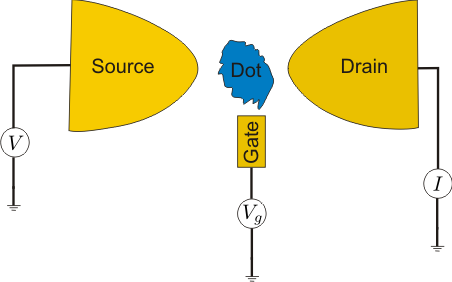

In [3]:
Image(filename='images/dot_transistor.png')

### Hamiltonian

Such a system can be modelled using so-called Anderson type Hamiltonian

$H=H_{\mathrm{leads}}+H_{\mathrm{tunneling}}+H_{\mathrm{dot}}$

where $H_{\mathrm{leads}}$ describes electrons in the leads, $H_{\mathrm{dot}}$ describes electrons in the dot, and $H_{\mathrm{tunneling}}$ corresponds to tunneling between the leads and the dot. In QmeQ package some simplifications are made for the model.

#### Leads
The leads in such models are described as non-interacting electrons

$H_{\mathrm{leads}}=\sum_{\alpha k}\varepsilon_{\alpha k}^{\phantom{\dagger}}c^{\dagger}_{\alpha k}c^{\phantom{\dagger}}_{\alpha k}$

It is assumed that the leads have constant density of states $\nu_{F}$ (subscript $F$ corresponds to the Fermi level). Then the $k$-sums are performed as $\sum_{k}\ldots\rightarrow\nu_{F}\int_{-D}^{+D}\mathrm{d}E\ldots$, where $D$ denotes bandwidht of the leads. Additionally, we assume that the leads are thermalized according to a Fermi-Dirac occupation function $f_{\alpha}(E)=[e^{(E-\mu_{\alpha})/T_\alpha}+1]^{-1}$ with temperature $T_{\alpha}$ and chemical potential $\mu_{\alpha}$.

#### Quantum dot
For the quantum dot the following rather general many-body Hamiltonian is used

$H_{\mathrm{dot}} = H_{\mathrm{single}}+H_{\mathrm{Coulomb}}$

$H_{\mathrm{single}}=\sum_{i}\varepsilon_{i}^{\phantom{\dagger}}d^{\dagger}_{i}d^{\phantom{\dagger}}_{i}+\sum_{i\neq j}t_{ij}^{\phantom{\dagger}}d^{\dagger}_{i}d^{\phantom{\dagger}}_{j}$

$H_{\mathrm{Coulomb}}=\sum_{mnkl}U_{mnkl}d^{\dagger}_{m}d^{\dagger}_{n}d_{k}d_{l},$

where the interaction $U_{mnkl}$ can be present.

#### Tunneling 
The tunneling Hamiltonian is

$H_{\mathrm{tunneling}}=\sum_{\alpha k i}t_{\alpha i}^{\phantom{\dagger}}c^{\dagger}_{\alpha k}d_{i}^{\phantom{\dagger}}+\mathrm{H.c.}$

Here we assume that tunneling amplitudes are energy (or $k$) independent, i.e., $t_{\alpha i k}\approx t_{\alpha i}$. An important energy scale in the calculations is a tunneling rate between the dot and the leads defined as $\Gamma_{\alpha i}=2\pi\nu_{F}\lvert{t_{\alpha i}}\rvert^2$.

### Single orbital example
Let us consider an example of a quantum dot containing one spinful orbital and on-site charging energy $U$ coupled to source ($L$) and drain ($R$) leads:

$H_{\mathrm{one}}=\sum_{\substack{k;\ell=L,R \\ \sigma=\uparrow,\downarrow}}\varepsilon_{\ell\sigma k}^{\phantom{\dagger}}c_{\ell\sigma k}^{\dagger}c_{\ell\sigma k}^{\phantom{\dagger}}
+\sum_{\ell\sigma k}\left(t_{\ell\sigma}c_{\ell\sigma k}^{\dagger}d_{\sigma}+\mathrm{H.c.}\right)
+\sum_{\sigma}\varepsilon_{\sigma}d_{\sigma}^{\dagger}d_{\sigma}
+(\Omega d_{\uparrow}^{\dagger}d_{\downarrow}+\mathrm{H.c.})
+Ud_{\uparrow}^{\dagger}d_{\downarrow}^{\dagger}d_{\downarrow}^{\phantom{\dagger}}d_{\uparrow}^{\phantom{\dagger}}$    

with $\varepsilon_{\uparrow}=V_{g}+\frac{B}{2}$, $\varepsilon_{\downarrow}=V_{g}-\frac{B}{2}$, where $V_{g}$ is the gate voltage and $B$ is the magnetic field (representing anamolous Zeeman splitting of spinful orbital). We note that in our calculations we set $\lvert{e}\rvert=1$, $\hbar=1$, $k_{\mathrm{B}}=1$, and deal with the particle currents.  We choose such values for parameters:

In [4]:
# Quantum dot parameters
vgate = 0.0
bfield = 0.0
omega = 0.0
U = 20.0

In [5]:
# Lead parameters
vbias = 0.5
temp = 1.0
dband = 60.0
# Tunneling amplitudes
gam = 0.5
t0 = np.sqrt(gam/(2*np.pi))

Here the variable *gam* is $\Gamma=2\pi\nu_{F}\lvert t_{0}\rvert^2$ and all the tunneling amplitudes will be given in terms of $t_{0}=\sqrt{\Gamma/(2\pi\nu_{F})}$. See **Remark on units** at the end of the tutorial why we do not specify density of states in t0 = np.sqrt(gam/(2*np.pi)).

The system corresponding to $H_{\mathrm{one}}$ is constructed using **Builder** function. For **Builder** to return a valid system we need to specify at least the following variables:

*nsingle* - number of single particles states    
*hsingle* - single particle Hamiltonian  ($H_{\mathrm{single}}$ defined above)    
*coulomb* - Coulomb matrix elements    
*nleads* - number of the leads    
*tleads* - single particle tunneling amplitudes    
*mulst* - chemical potentials of the leads    
*tlst* - temperatures of the leads    
*dband* - bandwidht of the leads

In $H_{\mathrm{one}}$ we have two single particle states $\lvert\uparrow\rangle$ and $\lvert\downarrow\rangle$. The single particle Hamiltonian $H_{\mathrm{single}}$ is specified using the following dictionary:

In [6]:
nsingle = 2

# 0 is up, 1 is down
hsingle = {(0, 0): vgate+bfield/2,
           (1, 1): vgate-bfield/2,
           (0, 1): omega}

**Comment 1.** We note that in a dictionary it is enough to specify one element like $\Omega d_{\uparrow}^{\dagger}d_{\downarrow}^{\phantom{\dagger}}$, because the other one $\Omega^{*} d_{\downarrow}^{\dagger}d_{\uparrow}^{\phantom{\dagger}}$ is determined by complex conjugation and is included automatically. Also if an element like (1,0) is given then it will be added to the Hamiltonian. So specifying {(0, 1):omega, (1,0):omega.conjugate()} will simply double count $\Omega$.

The Coulomb interaction Hamiltonian $H_{\mathrm{Coulomb}}$ is specified using a dictionary:

In [7]:
coulomb = {(0,1,1,0):U}

The tunneling Hamiltonian $H_{\mathrm{tunneling}}$ can be specified as:

In [8]:
tleads = {(0, 0):t0, # L, up   <-- up
          (1, 0):t0, # R, up   <-- up
          (2, 1):t0, # L, down <-- down         
          (3, 1):t0} # R, down <-- down
                     # lead label, lead spin <-- level spin

**Comment 2.** In dictionary tuple $(\alpha, i)$ the first label $\alpha$ denotes lead quantum numbers, the second label $i$ denotes levels of the quantum dot. We note that effectively we get four leads, i.e., $\alpha\in\{L\uparrow,R\uparrow,L\downarrow,R\downarrow\}$.

Now we define the number of leads and the lead properties in the lists *mulst*, *tlst* (*dband* was defined previously):

In [9]:
nleads = 4

#        L,up        R,up         L,down      R,down
mulst = {0: vbias/2, 1: -vbias/2, 2: vbias/2, 3: -vbias/2}
tlst =  {0: temp,    1: temp,     2: temp,    3: temp}

#### Pauli, Redfield, and 1vN methods

At last we can construct our system using **qmeq.Builder** as:

In [10]:
system = qmeq.Builder(nsingle, hsingle, coulomb,
                      nleads, tleads, mulst, tlst, dband,
                      kerntype='Pauli')

Here we have chosen to use **Pauli master equation** (*kerntype='Pauli'*) to describe the stationary state. Let's calculate the current through the system:

In [11]:
system.solve()
print('Pauli current:')
print(system.current)
print(system.energy_current)

Pauli current:
[ 0.0207255 -0.0207255  0.0207255 -0.0207255]
[  1.73557597e-09  -1.73557597e-09   1.73557597e-09  -1.73557597e-09]


The four entries correspond to current in $L\uparrow$, $L\downarrow$, $R\uparrow$, $R\downarrow$ lead channels. We see that the current through left lead and right lead channels is conserved up to numerical errors:

In [12]:
print('Current continuity:')
print(np.sum(system.current))

Current continuity:
2.77555756156e-17


If we want to change the method we could redefine the system with the **qmeq.Builder** by specifying the new *kerntype*. It is also possible just to change the value of *system.kerntype*:

In [13]:
kernels = ['Redfield', '1vN', 'Lindblad', 'Pauli']
for kerntype in kernels:
    system.kerntype = kerntype
    system.solve()
    print(kerntype, ' current:')
    print(system.current)

Redfield  current:
[ 0.0207255 -0.0207255  0.0207255 -0.0207255]
1vN  current:
[ 0.0207255 -0.0207255  0.0207255 -0.0207255]
Lindblad  current:
[ 0.0207255 -0.0207255  0.0207255 -0.0207255]
Pauli  current:
[ 0.0207255 -0.0207255  0.0207255 -0.0207255]


We see that for our considered system Pauli, Redfield, and 1vN methods yield the same results. This is so, because for given parameter values the spin is a good quantum number and no coherences between $\lvert\uparrow\rangle$ and $\lvert\downarrow\rangle$ are developed.

#### 2vN method

In order to use 2vN method we need to rebuild the system, because the solution method ir rather different. It is described by **Transport2vN** object and not **Transport** object. We also need to specify a number of points *kpnt* in an equidistant energy grid on which the 2vN calculations are performed (iterative solution of an integral equation):

In [14]:
kpnt = np.power(2,12)
system2vN = qmeq.Builder(nsingle, hsingle, coulomb, nleads, 
                         tleads, mulst, tlst, dband,
                         kerntype='2vN', kpnt=kpnt)

Solve the 2vN integral equations using 7 iterations:

In [15]:
system2vN.solve(niter=7)

In [16]:
print('Particle current:')
print(system2vN.current)
print('Energy current:')
print(system2vN.energy_current)

Particle current:
[ 0.01595739+0.j -0.01595739+0.j  0.01595739+0.j -0.01595739+0.j]
Energy current:
[ 0.00599524+0.j -0.00599523+0.j  0.00599524+0.j -0.00599523+0.j]


We can check the current for every iteration to see if it has converged:

In [17]:
for i in range(system2vN.niter+1):
    print(i, system2vN.iters[i].current)

0 [ 0.01505524+0.j -0.01505524+0.j  0.01505524+0.j -0.01505524+0.j]
1 [ 0.01589457+0.j -0.01589457+0.j  0.01589457+0.j -0.01589457+0.j]
2 [ 0.01595427+0.j -0.01595427+0.j  0.01595427+0.j -0.01595427+0.j]
3 [ 0.0159572+0.j -0.0159572+0.j  0.0159572+0.j -0.0159572+0.j]
4 [ 0.01595738+0.j -0.01595738+0.j  0.01595738+0.j -0.01595738+0.j]
5 [ 0.01595739+0.j -0.01595739+0.j  0.01595739+0.j -0.01595739+0.j]
6 [ 0.01595739+0.j -0.01595739+0.j  0.01595739+0.j -0.01595739+0.j]


### Stability diagram

Usually in experiments there is control of bias $V$ and gate voltage $V_{g}$. A contour plot of current or conductance in $(V, V_{g})$ plane is called a stability diagram. Let's produce such stability diagram for our quantum dot using **Pauli master equation**:

In [18]:
def stab_calc(system, bfield, vlst, vglst, dV=0.0001):    
    vpnt, vgpnt = vlst.shape[0], vglst.shape[0]
    stab = np.zeros((vpnt, vgpnt))
    stab_cond = np.zeros((vpnt, vgpnt))
    #
    for j1 in range(vgpnt):    
        system.change(hsingle={(0,0):vglst[j1]+bfield/2,
                               (1,1):vglst[j1]-bfield/2})
        system.solve(masterq=False)
        for j2 in range(vpnt):            
            system.change(mulst={0: vlst[j2]/2, 1: -vlst[j2]/2,
                                 2: vlst[j2]/2, 3: -vlst[j2]/2})
            system.solve(qdq=False)
            stab[j1, j2] = system.current[0] + system.current[2]
            #            
            system.add(mulst={0: dV/2, 1: -dV/2,
                              2: dV/2, 3: -dV/2})
            system.solve(qdq=False)
            stab_cond[j1, j2] = (system.current[0] + system.current[2] - stab[j1, j2])/dV
    #
    return stab, stab_cond

We changed the single particle Hamiltonian by calling the function **system.change** and specifying which matrix elements to change. The function **system.add** adds a value to a specified parameter. Also the option *masterq=False* in **system.solve** indicates just to diagonalise the quantum dot Hamiltonian and the master equation is not solved. Similarly the option *qdq=False* means that the quantum dot Hamiltonian is not touched and just master equation is solved.

In [19]:
system.kerntype = 'Pauli'
vpnt, vgpnt = 201, 201
vlst = np.linspace(-2*U, 2*U, vpnt)
vglst = np.linspace(-2.5*U, 1.5*U, vgpnt)
stab, stab_cond = stab_calc(system, bfield, vlst, vglst)

The stability diagram has been produced. Let's see how it looks like:

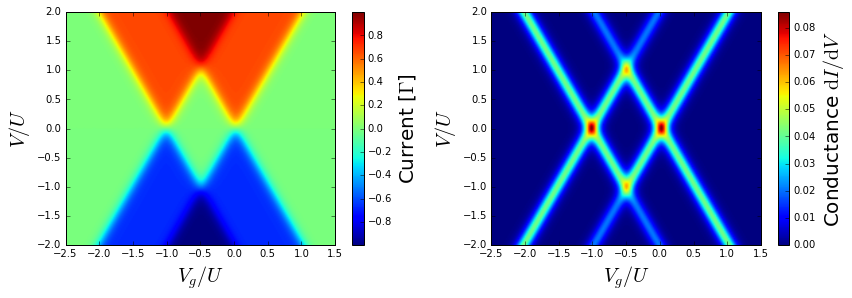

In [20]:
def stab_plot(stab, stab_cond, vlst, vglst, U, gam):
    (xmin, xmax, ymin, ymax) = np.array([vglst[0], vglst[-1], vlst[0], vlst[-1]])/U
    fig = plt.figure(figsize=(12,4.2))
    #
    p1 = plt.subplot(1, 2, 1)
    p1.set_xlabel('$V_{g}/U$', fontsize=20) 
    p1.set_ylabel('$V/U$', fontsize=20)
    p1_im = plt.imshow(stab.T/gam, extent=[xmin, xmax, ymin, ymax], aspect='auto', origin='lower')
    cbar1 = plt.colorbar(p1_im)
    cbar1.set_label('Current [$\Gamma$]', fontsize=20)
    #
    p2 = plt.subplot(1, 2, 2)
    p2.set_xlabel('$V_{g}/U$', fontsize=20); 
    p2.set_ylabel('$V/U$', fontsize=20); 
    p2_im = plt.imshow(stab_cond.T, extent=[xmin, xmax, ymin, ymax], aspect='auto', origin='lower')
    cbar2 = plt.colorbar(p2_im)
    cbar2.set_label('Conductance $\mathrm{d}I/\mathrm{d}V$', fontsize=20)
    #
    plt.tight_layout()    
    
stab_plot(stab, stab_cond, vlst, vglst, U, gam)

If Zeeman splitting of the orbital is included we get stability diagram where split excited states can be seen:

In [21]:
stab_b, stab_cond_b = stab_calc(system, 7.5, vlst, vglst)

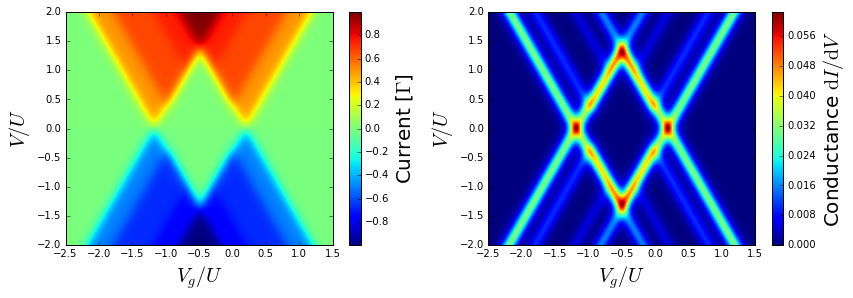

In [22]:
stab_plot(stab_b, stab_cond_b, vlst, vglst, U, gam)

### Remark on units

The inputed tunneling amplitudes $\mathrm{t}_{\alpha i}$ in *tleads* correspond to tunneling amplitudes $t_{\alpha i}$ weighted by density of states $\nu_{F}$ in the following way:

$\mathrm{t}_{\alpha i}=\frac{1}{\sqrt{\nu_{F}}}t_{\alpha i}.$

Then the tunneling rates simply become $\Gamma_{\alpha i}=2\pi\lvert{\mathrm{t}_{\alpha i}}\rvert^2$. Also in the case when different lead channels can have different density of states $\nu_{\alpha i}$ any difference can be absorbed into the tunneling amplitudes. This is why it was not necessary to specify $\nu_{F}$ in our example.

Throughout the calculations we have used $\hbar=1$ and considered particle currents instead of electrical currents. If we are interested in the case $\hbar\neq 1$, $\lvert{e}\rvert\neq 1$ and in electrical currents with cariers having a charge $e$ (which can be $e$<0) we need in the above stability diagrams make such replacements

$V\rightarrow eV,$

$V_{g}\rightarrow eV_{g},$

$I \ [\Gamma]\rightarrow I \ [e\Gamma/\hbar],$

$\frac{\mathrm{d}I}{\mathrm{d}V} \ [1]\rightarrow \frac{\mathrm{d}I}{\mathrm{d}V} \ [e^2/\hbar].$

Also to have the conductance in units of $G_{0}=e^2/h$ we would need to multiply the $\mathrm{d}I/\mathrm{d}V$ plots by $2\pi$.